# Análisis zonal de cambios urbanos – Pudahuel (2017–2024)

Este notebook implementa el análisis zonal de los cambios urbanos detectados en la comuna de Pudahuel,
utilizando una grilla regular como unidad espacial de análisis.

Se calculan, por zona:
- Porcentaje de pérdida significativa de vegetación (ΔNDVI < -0.2)
- Porcentaje de aumento significativo de áreas construidas (ΔNDBI > 0.2)

Los resultados se exportan como tabla CSV y sirven de base para mapas coropléticos
y análisis de patrones espaciales.



In [41]:
import os
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely.geometry as geom
from rasterio.features import geometry_mask
import matplotlib.pyplot as plt
import pyproj

# La ruta exacta que encontró tu búsqueda
PROJ_PATH = '/opt/conda/lib/python3.10/site-packages/pyproj/proj_dir/share/proj'

# Configurar variables de entorno para que rasterio y pyproj lo vean
os.environ['PROJ_LIB'] = PROJ_PATH
os.environ['PROJ_DATA'] = PROJ_PATH

# Notificar a la librería pyproj
pyproj.datadir.set_data_dir(PROJ_PATH)

print(f"✅ PROJ configurado exitosamente en: {PROJ_PATH}")
# --- 1. CONFIGURACIÓN DE RUTAS ABSOLUTAS ---
BASE_DIR = "/home/jovyan"
PATH_NDVI = os.path.join(BASE_DIR, "data/processed/delta_ndvi_2017_2024.tif")
PATH_NDBI = os.path.join(BASE_DIR, "data/processed/delta_ndbi_2017_2024.tif")

# --- 2. LECTURA DE DATOS ---
with rasterio.open(PATH_NDVI) as src:
    r_ndvi = src.read(1)
    bounds = src.bounds
    transform = src.transform
    crs_raster = src.crs

with rasterio.open(PATH_NDBI) as src:
    r_ndbi = src.read(1)

# --- 3. CREACIÓN DE LA GRILLA (Si no existe) ---
# Definimos el tamaño del cuadrante (ej: 0.005 grados ~ 500m)
step = 0.005 
xmin, ymin, xmax, ymax = bounds
cols = np.arange(xmin, xmax, step)
rows = np.arange(ymin, ymax, step)

polygons = []
for x in cols:
    for y in rows:
        polygons.append(geom.box(x, y, x + step, y + step))

grid = gpd.GeoDataFrame({'geometry': polygons}, crs=crs_raster)
print(f"Grilla creada con {len(grid)} cuadrantes.")

# --- 4. ANÁLISIS ZONAL OPTIMIZADO ---
results = []
# Pre-calculamos máscaras de cambio para ir más rápido
mask_loss = (r_ndvi < -0.2)
mask_gain = (r_ndbi > 0.2)

for idx, row in grid.iterrows():
    # Creamos la máscara para este cuadrante específico
    zone_mask = geometry_mask([row.geometry], out_shape=r_ndvi.shape, 
                              transform=transform, invert=True)
    
    n_pixels = zone_mask.sum()
    if n_pixels > 0:
        p_loss = (mask_loss & zone_mask).sum() / n_pixels * 100
        p_gain = (mask_gain & zone_mask).sum() / n_pixels * 100
        results.append({'zone_id': idx, 'perc_loss_veg': p_loss, 'perc_gain_built': p_gain})
    else:
        results.append({'zone_id': idx, 'perc_loss_veg': 0, 'perc_gain_built': 0})

# Unir resultados a la grilla
df_results = pd.DataFrame(results)
grid = grid.merge(df_results, left_index=True, right_on='zone_id')

print(grid)
print("✅ Análisis zonal completado.")

✅ PROJ configurado exitosamente en: /opt/conda/lib/python3.10/site-packages/pyproj/proj_dir/share/proj
Grilla creada con 1599 cuadrantes.
                                               geometry  zone_id  \
0     POLYGON ((-70.92508 -33.48012, -70.92508 -33.4...        0   
1     POLYGON ((-70.92508 -33.47512, -70.92508 -33.4...        1   
2     POLYGON ((-70.92508 -33.47012, -70.92508 -33.4...        2   
3     POLYGON ((-70.92508 -33.46512, -70.92508 -33.4...        3   
4     POLYGON ((-70.92508 -33.46012, -70.92508 -33.4...        4   
...                                                 ...      ...   
1594  POLYGON ((-70.73508 -33.30012, -70.73508 -33.2...     1594   
1595  POLYGON ((-70.73508 -33.29512, -70.73508 -33.2...     1595   
1596  POLYGON ((-70.73508 -33.29012, -70.73508 -33.2...     1596   
1597  POLYGON ((-70.73508 -33.28512, -70.73508 -33.2...     1597   
1598  POLYGON ((-70.73508 -33.28012, -70.73508 -33.2...     1598   

      perc_loss_veg  perc_gain_built  
0     

In [31]:
# ==========================================================
# 1. EXPORTACIÓN DE DATOS (CORREGIDO PARA FOLIUM)
# ==========================================================
import os

# Definir la ruta de salida
output_path = "/home/jovyan/data/processed/cambios_por_zona.gpkg"
output_csv = "/home/jovyan/outputs/cambios_por_zona_pudahuel.csv"

# Asegurar que los directorios existen
os.makedirs(os.path.dirname(output_path), exist_ok=True)
os.makedirs(os.path.dirname(output_csv), exist_ok=True)

# --- PASOS CRÍTICOS PARA EL DASHBOARD ---
# 1. Nos aseguramos de que 'zone_id' sea una columna real y no un índice
if 'zone_id' not in grid.columns:
    grid = grid.reset_index().rename(columns={'index': 'zone_id'})

# 2. Forzamos que zone_id sea tipo string (Folium prefiere strings para vincular datos)
grid['zone_id'] = grid['zone_id'].astype(str)

# 3. Exportar el GeoDataFrame
# Usamos index=False para que no cree columnas extra de índice que confundan a Folium
grid.to_file(output_path, driver="GPKG", index=False)

# También exportamos el CSV
grid.drop(columns='geometry').to_csv(output_csv, index=False)

print(f"✅ GPKG actualizado con zone_id como string: {output_path}")

✅ GPKG actualizado con zone_id como string: /home/jovyan/data/processed/cambios_por_zona.gpkg


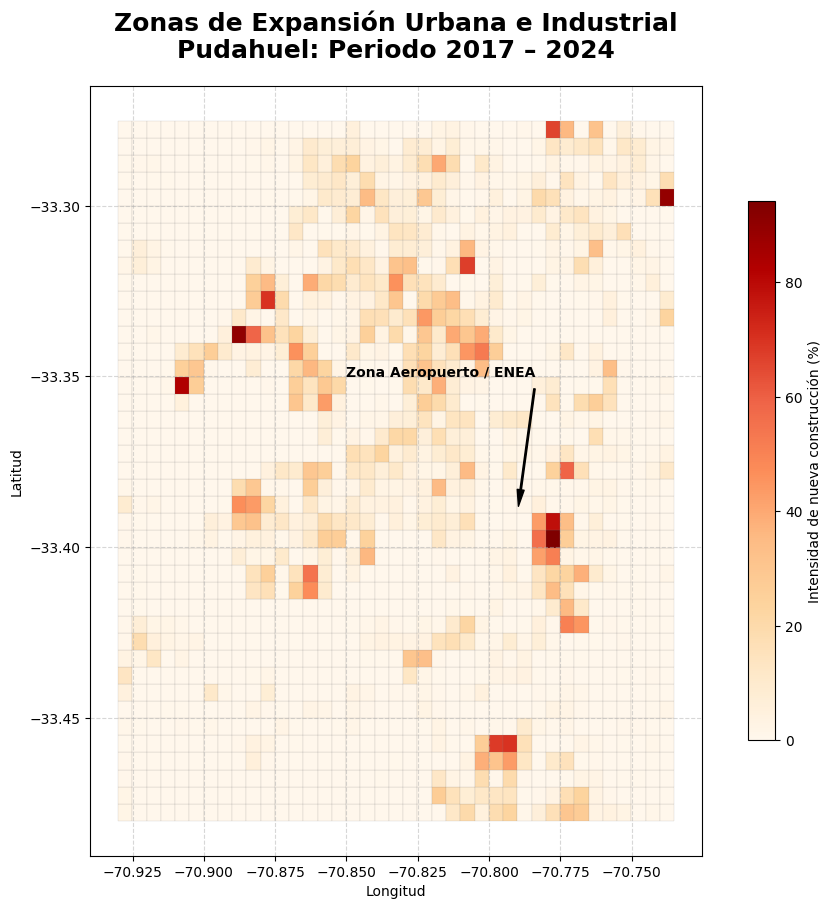

✅ Mapa coroplético generado en: /home/jovyan/outputs/figures/mapa_zonal_cambio_urbano.png


In [32]:
import matplotlib.patches as mpatches

# --- 1. CONFIGURACIÓN DEL MAPA ---
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Definimos un esquema de color que resalte el "calor" del cemento (OrRd: Orange to Red)
# El parámetro 'scheme' permite clasificar los datos si tienes muchos cuadrantes en 0
plot_grid = grid[grid['perc_gain_built'] > 0] # Filtramos para no pintar donde no hay cambio

grid.plot(
    column="perc_gain_built",
    cmap="OrRd",
    linewidth=0.1,
    edgecolor="0.5",
    legend=True,
    legend_kwds={
        'label': "Intensidad de nueva construcción (%)",
        'orientation': "vertical",
        'shrink': 0.7
    },
    ax=ax,
    missing_kwds={"color": "#eeeeee", "label": "Sin cambio detectado"} # Zonas grises = sin cambio
)

# --- 2. PERSONALIZACIÓN Y ETIQUETAS ---
ax.set_title(
    "Zonas de Expansión Urbana e Industrial\nPudahuel: Periodo 2017 – 2024", 
    fontsize=18, fontweight='bold', pad=20
)

# Añadimos cuadrícula de coordenadas (opcional pero profesional)
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlabel("Longitud", fontsize=10)
ax.set_ylabel("Latitud", fontsize=10)

# --- 3. ANOTACIONES DE REFERENCIA ---
# Puedes ajustar estas coordenadas si conoces puntos específicos (como el Aeropuerto)
# Esto ayuda a que el lector se ubique espacialmente
ax.annotate('Zona Aeropuerto / ENEA', xy=(-70.79, -33.39), xytext=(-70.85, -33.35),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
            fontsize=10, fontweight='bold')

# --- 4. GUARDADO ---
out_map_path = os.path.join(BASE_DIR, "outputs/figures/mapa_zonal_cambio_urbano.png")
plt.savefig(out_map_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Mapa coroplético generado en: {out_map_path}")

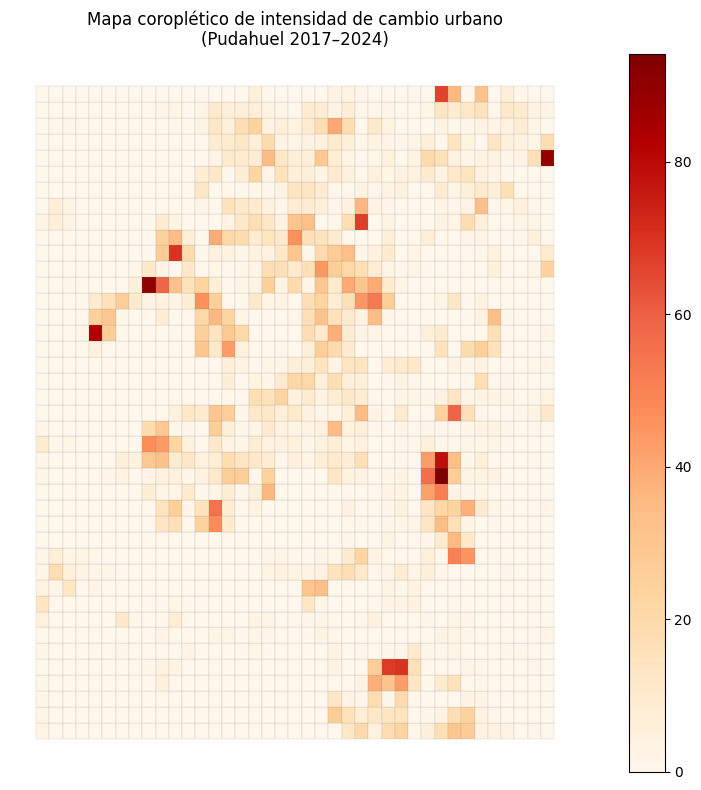

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

grid.plot(
    column="perc_gain_built",
    cmap="OrRd",
    linewidth=0.1,
    edgecolor="grey",
    legend=True,
    ax=ax
)

ax.set_title(
    "Mapa coroplético de intensidad de cambio urbano\n(Pudahuel 2017–2024)",
    fontsize=12
)
ax.axis("off")

plt.tight_layout()

# Crear la subcarpeta si no existe
os.makedirs("outputs/figures", exist_ok=True)

# Ahora sí puedes guardar
plt.savefig(
    "outputs/figures/mapa_coropletico_cambio.png",
    dpi=300,
    bbox_inches='tight' # Recomendado para que no se corten las etiquetas
)

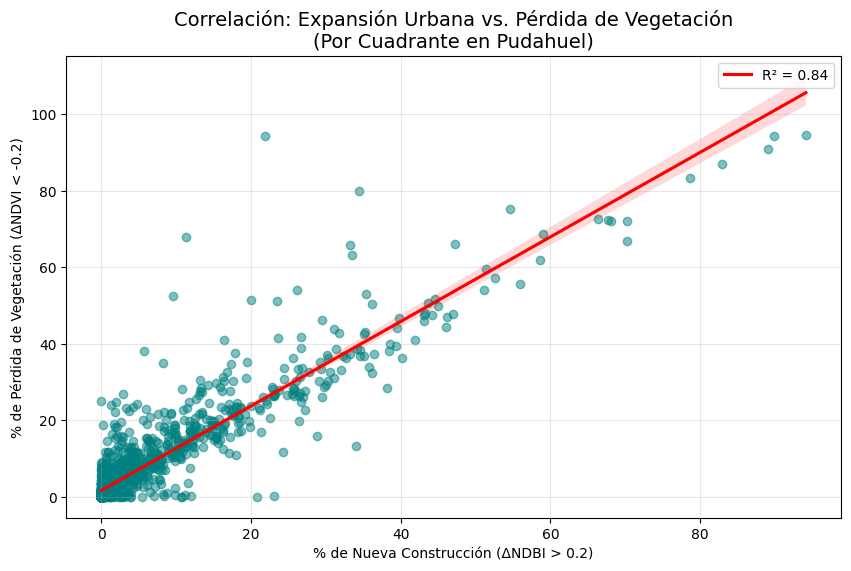

Coeficiente de determinación (R²): 0.8415
✅ La correlación es estadísticamente significativa.


In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# --- 1. PREPARACIÓN DE DATOS ---
# Usamos el GeoDataFrame 'grid' que ya tiene las estadísticas zonales
df_analisis = grid[['perc_loss_veg', 'perc_gain_built', 'zone_id']].copy()

# --- 2. CÁLCULO DE CORRELACIÓN ---
# Queremos ver si donde sube el NDBI, baja el NDVI
slope, intercept, r_value, p_value, std_err = stats.linregress(df_analisis['perc_gain_built'], df_analisis['perc_loss_veg'])

# --- 3. VISUALIZACIÓN DE DISPERSIÓN (SCATTER PLOT) ---
plt.figure(figsize=(10, 6))
sns.regplot(data=df_analisis, x='perc_gain_built', y='perc_loss_veg', 
            scatter_kws={'alpha':0.5, 'color':'teal'}, 
            line_kws={'color':'red', 'label':f'R² = {r_value**2:.2f}'})

plt.title("Correlación: Expansión Urbana vs. Pérdida de Vegetación\n(Por Cuadrante en Pudahuel)", fontsize=14)
plt.xlabel("% de Nueva Construcción (ΔNDBI > 0.2)")
plt.ylabel("% de Pérdida de Vegetación (ΔNDVI < -0.2)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("/home/jovyan/outputs/figures/correlacion_urbana.png", dpi=200)
plt.show()

print(f"Coeficiente de determinación (R²): {r_value**2:.4f}")
if p_value < 0.05:
    print("✅ La correlación es estadísticamente significativa.")

Se han detectado 109 cuadrantes de cambio crítico.


/tmp/ipykernel_856/2059633571.py:15: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


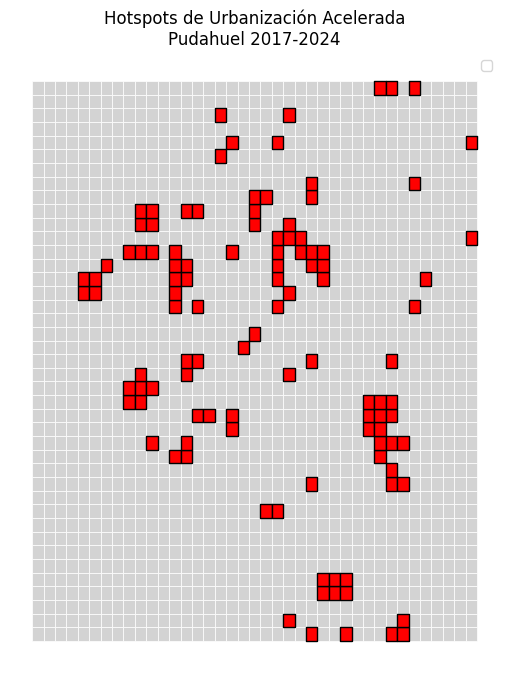

In [35]:
# --- 4. DETECCIÓN DE CUADRANTES CRÍTICOS ---
# Definimos "Hotspot" como zona con > 20% de ganancia de cemento Y > 20% de pérdida de verde
hotspots = grid[(grid['perc_gain_built'] > 20) & (grid['perc_loss_veg'] > 20)]

print(f"Se han detectado {len(hotspots)} cuadrantes de cambio crítico.")

# Visualización de Hotspots sobre el mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
grid.plot(ax=ax, color='lightgrey', edgecolor='white', linewidth=0.5)
if not hotspots.empty:
    hotspots.plot(ax=ax, color='red', edgecolor='black', label='Cambio Crítico')

ax.set_title("Hotspots de Urbanización Acelerada\nPudahuel 2017-2024")
ax.axis("off")
plt.legend()
plt.show()

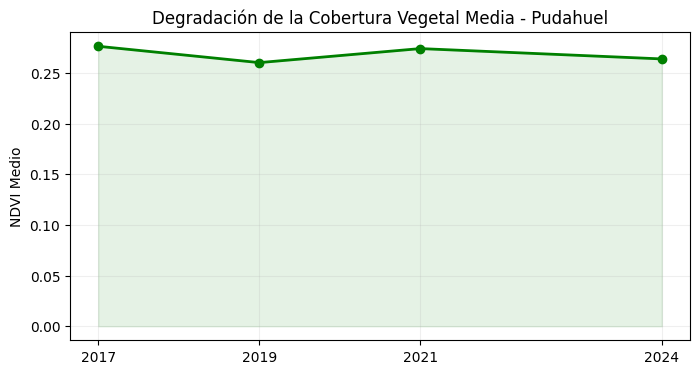

In [36]:
# --- 5. ANÁLISIS DE TENDENCIA TEMPORAL ---
años = [2017, 2019, 2021, 2024]
medias_ndvi = []

for año in años:
    ruta = f"/home/jovyan/data/processed/ndvi_pudahuel_{año}.tif"
    with rasterio.open(ruta) as src:
        data = src.read(1)
        medias_ndvi.append(np.nanmean(data[data != -9999])) # Ajustar según tu valor NoData

# Crear DataFrame de tendencia
df_tendencia = pd.DataFrame({'Año': años, 'NDVI_Promedio': medias_ndvi})

plt.figure(figsize=(8, 4))
plt.plot(df_tendencia['Año'], df_tendencia['NDVI_Promedio'], marker='o', color='green', linewidth=2)
plt.fill_between(df_tendencia['Año'], df_tendencia['NDVI_Promedio'], alpha=0.1, color='green')
plt.title("Degradación de la Cobertura Vegetal Media - Pudahuel")
plt.ylabel("NDVI Medio")
plt.grid(True, alpha=0.2)
plt.xticks(años)
plt.savefig("/home/jovyan/outputs/figures/tendencia_temporal_ndvi.png")
plt.show()